In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from rich import print as printr
import numpy as np
from pathlib import Path
from instance_dac.utils.data_loading import load_performance_data, load_eval_data

# LEVELS OF AGGREGATION
# 1. eval episode
# 2. seed
# 3. instance

# data.csv missing? Run
path = "../runs/Sigmoid"
train_instance_set = "2D3M_train"
train_instance_set_id = "sigmoid_2D3M_train"
path = Path(path) / train_instance_set
#----> data = load_eval_data(path=path, train_instance_set_id=train_instance_set_id)

data = pd.read_csv("eval_data.csv")
del data["Unnamed: 0"]

ids = data["origin"] == "selector"
data["origin"][ids] = data["instance_set_id"][ids].apply(lambda x: f"selector_{x}")

# Add random performance
random_perf_path = Path("../runs/random/Sigmoid/2D3M_train/full")
if random_perf_path.exists():
    perf_data = load_performance_data(random_perf_path)
    perf_data["origin"] = "random"
    data = pd.concat([data, perf_data])
    del perf_data
data

DACBench Gym registration failed - make sure you have all dependencies installed and their instance sets in the right path!


Output()

[PosixPath('../runs/random/Sigmoid/2D3M_train/full/2/logs/eval/sigmoid_2D3M_train/PerformanceTrackingWrapper.jsonl'), PosixPath('../runs/random/Sigmoid/2D3M_train/full/8/logs/eval/sigmoid_2D3M_train/PerformanceTrackingWrapper.jsonl'), PosixPath('../runs/random/Sigmoid/2D3M_train/full/10/logs/eval/sigmoid_2D3M_train/PerformanceTrackingWrapper.jsonl'), PosixPath('../runs/random/Sigmoid/2D3M_train/full/7/logs/eval/sigmoid_2D3M_train/PerformanceTrackingWrapper.jsonl'), PosixPath('../runs/random/Sigmoid/2D3M_train/full/5/logs/eval/sigmoid_2D3M_train/PerformanceTrackingWrapper.jsonl'), PosixPath('../runs/random/Sigmoid/2D3M_train/full/6/logs/eval/sigmoid_2D3M_train/PerformanceTrackingWrapper.jsonl'), PosixPath('../runs/random/Sigmoid/2D3M_train/full/9/logs/eval/sigmoid_2D3M_train/PerformanceTrackingWrapper.jsonl'), PosixPath('../runs/random/Sigmoid/2D3M_train/full/4/logs/eval/sigmoid_2D3M_train/PerformanceTrackingWrapper.jsonl'), PosixPath('../runs/random/Sigmoid/2D3M_train/full/3/logs/eval/

episode  step  instance  seed  overall_performance instance_set_id  \
0            0     9         1     9             3.814478      2D3M_train   
1            1     9         2     9             2.845407      2D3M_train   
2            2     9         3     9             2.544689      2D3M_train   
3            3     9         4     9             4.112416      2D3M_train   
4            4     9         5     9             3.466814      2D3M_train   
...        ...   ...       ...   ...                  ...             ...   
29995     2995     9       296     1             3.415960      2D3M_train   
29996     2996     9       297     1             1.588192      2D3M_train   
29997     2997     9       298     1             2.850883      2D3M_train   
29998     2998     9       299     1             2.997332      2D3M_train   
29999     2999     9         0     1             1.480863      2D3M_train   

       origin  
0        full  
1        full  
2        full  
3        full  
4        full  
...       ...  
29995  random  
29996  random  
29997  random  
29998  random  
29999  random  

[4890000 rows x 7 columns]

In [2]:
# Aggregate across eval episodes
perf = pd.DataFrame(data.groupby(["origin", "seed", "instance"])["overall_performance"].mean())
perf_dict = {}
for gid, gdf in perf.groupby("origin"):
    gdf = gdf.reset_index()
    P = gdf["overall_performance"].to_numpy()
    P = P.reshape((gdf["seed"].nunique(), gdf["instance"].nunique()))
    perf_dict[gid] = P

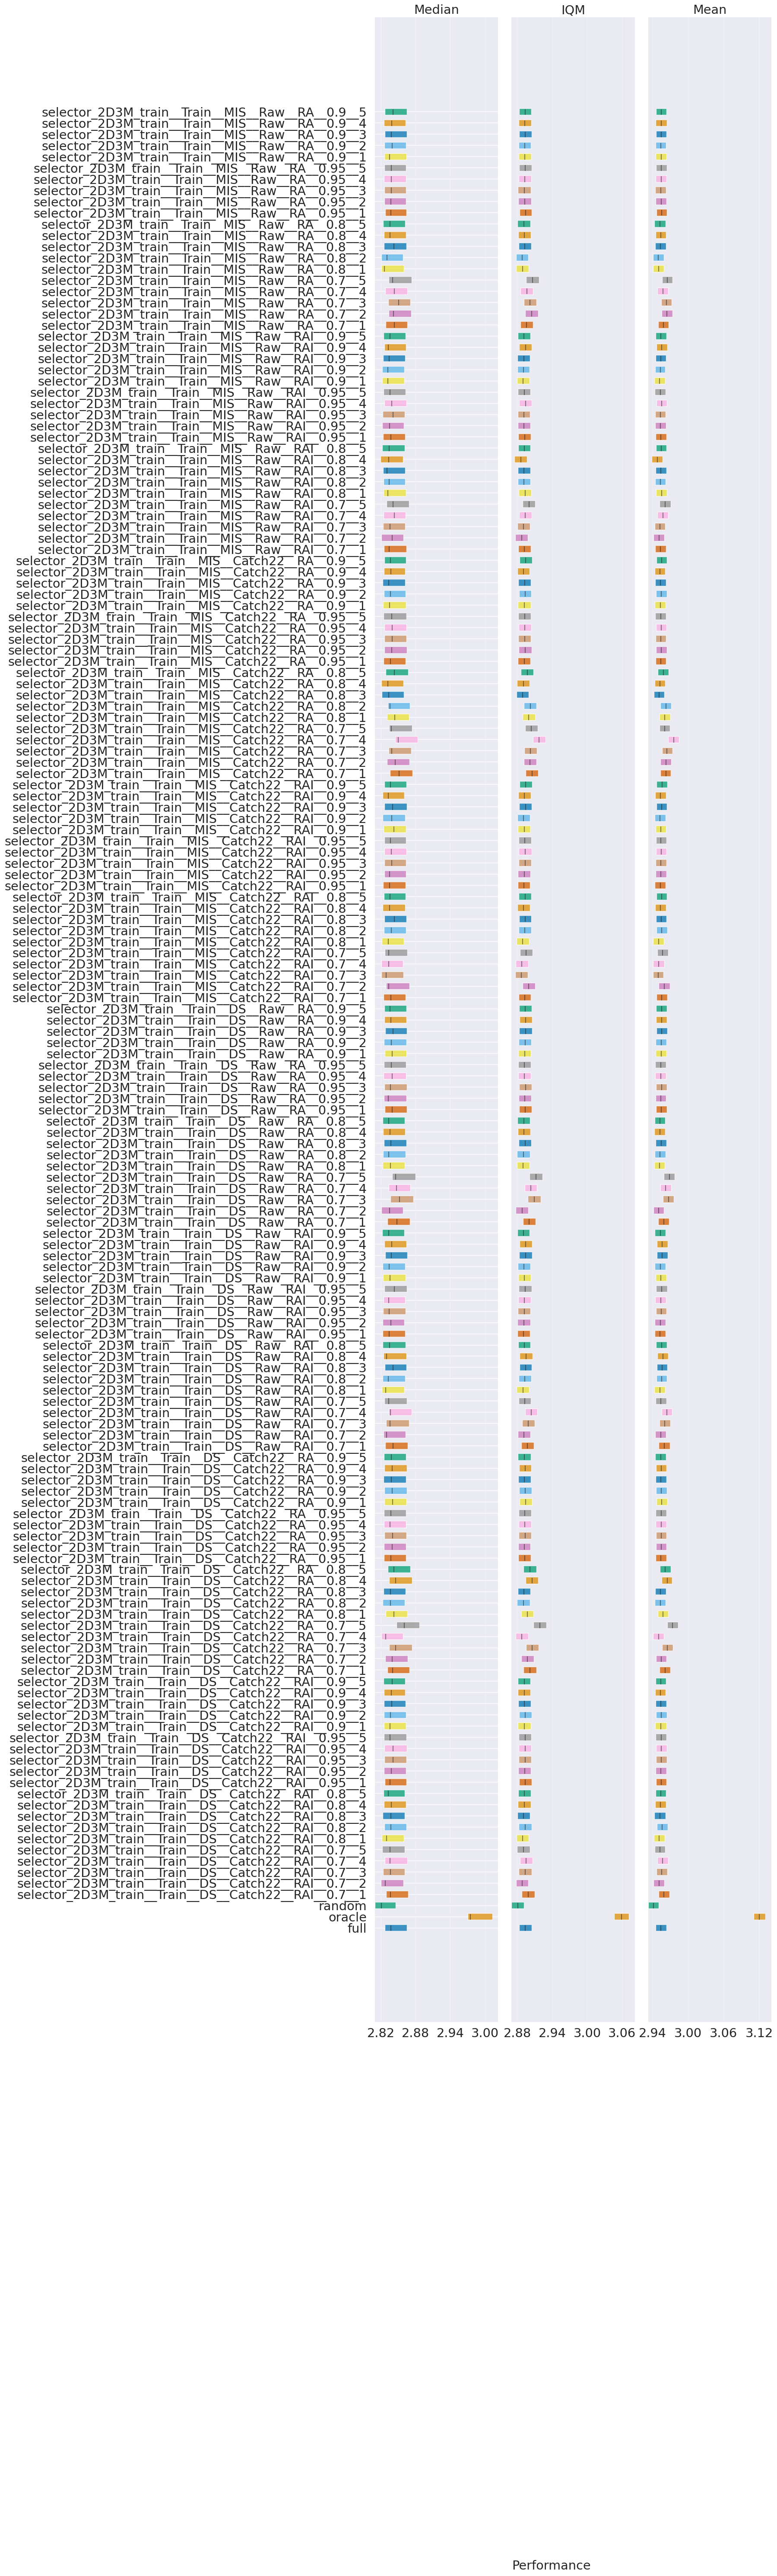

In [3]:
from rliable import library as rly
from rliable import metrics
from rliable import plot_utils

metric_names = ['Median', 'IQM', 'Mean']#, 'Optimality Gap']

algorithms = list(perf_dict.keys())
# Load ALE scores as a dictionary mapping algorithms to their human normalized
# score matrices, each of which is of size `(num_runs x num_games)`.
aggregate_func = lambda x: np.array([
  metrics.aggregate_median(x),
  metrics.aggregate_iqm(x),
  metrics.aggregate_mean(x),
  #metrics.aggregate_optimality_gap(x)
  ])
aggregate_scores, aggregate_score_cis = rly.get_interval_estimates(
  perf_dict, aggregate_func, reps=5000)
fig, axes = plot_utils.plot_interval_estimates(
  aggregate_scores, aggregate_score_cis,
  metric_names=metric_names,
  algorithms=algorithms, xlabel='Performance')

In [4]:
D = []
for key, value in aggregate_scores.items():
    d = {
        "origin": key,
    }
    d.update({m: v for m, v in zip(metric_names, value)})
    D.append(d)
df_scores = pd.DataFrame(D)

# Highest IQM
printr("Highest IQM")
ind = np.argpartition(df_scores["IQM"], -2)[-2:][0]  # select 2nd best because best is oracle
printr(df_scores.iloc[ind])
printr(df_scores.iloc[ind]["origin"])

# IQM Full
printr("IQM full")
printr(df_scores[df_scores["origin"] == "full"].iloc[0])


Highest IQM

origin    selector_2D3M_train__Train__DS__Catch22__RA__0...
Median                                             2.860843
IQM                                                2.918916
Mean                                               2.974229
Name: 27, dtype: object

IQM full

origin        full
Median    2.837511
IQM       2.893526
Mean      2.954524
Name: 0, dtype: object

<Axes: xlabel='Overall Performance $(\\tau)$', ylabel='Fraction of runs with score $> \\tau$'>

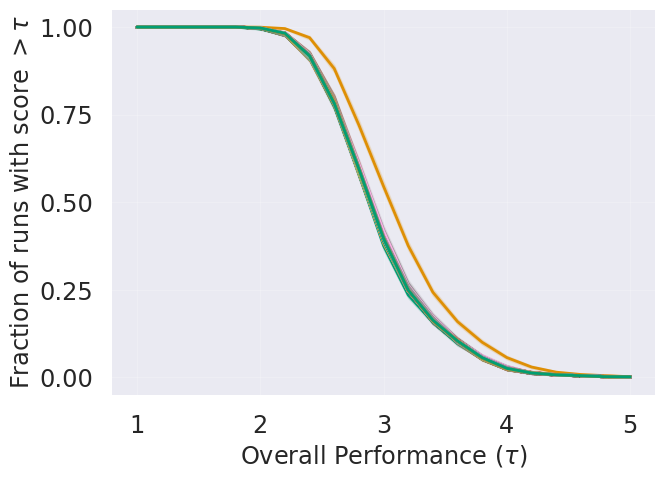

In [5]:
tau_list = np.linspace(1, 5, 21)
score_distributions, score_distributions_cis = rly.create_performance_profile(
    perf_dict, tau_list=tau_list)
# Plot score distributions
fig, ax = plt.subplots(ncols=1, figsize=(7, 5))
plot_utils.plot_performance_profiles(
  score_distributions, tau_list=tau_list,
  performance_profile_cis=score_distributions_cis,
  # colors=dict(zip(algorithms, sns.color_palette('colorblind'))),
  xlabel=r'Overall Performance $(\tau)$',
  ax=ax)

In [6]:
perf = pd.DataFrame(data.groupby(["origin", "instance"])["overall_performance"].mean())
perf

overall_performance
origin                                           instance                     
full                                             0                    2.666800
                                                 1                    2.561815
                                                 2                    2.728713
                                                 3                    2.844557
                                                 4                    2.726168
...                                                                        ...
selector_2D3M_train__Train__MIS__Raw__RA__0.9__5 295                  2.761333
                                                 296                  3.459612
                                                 297                  2.738147
                                                 298                  2.411146
                                                 299                  2.647730

[48900 rows x 1 columns]

In [7]:
from functools import partial

def l1_dist(a, b) -> float:
    return a - b 

def l2_dist(a, b) -> float:
    return (a - b) ** 2

def calc_dist(x: pd.DataFrame, distance_function) -> pd.DataFrame:
    x = x.reset_index()
    instance_id = x["instance"][0]
    origins = x["origin"]
    groundtruth = "oracle"
    idx_gt = list(origins).index(groundtruth)
    dist = distance_function(x["overall_performance"][idx_gt], x["overall_performance"])
    comparison_names = [f"{groundtruth} - {origin}" for origin in origins]
    ret = pd.DataFrame({
        "instance": instance_id,
        "distance_name": distance_function.__name__,
        "distance": dist,
        "compared": comparison_names
    })
    return ret

distance_functions=[l1_dist, l2_dist]

# Compute distance between oracle performance and performance on full training set
diffs_per_instance = pd.concat([perf.groupby("instance").apply(calc_dist, distance_function=func) for func in distance_functions], axis=0).reset_index(drop=True)
diffs_per_instance

instance distance_name  distance  \
0             0       l1_dist  0.197633   
1             0       l1_dist  0.000000   
2             0       l1_dist  0.187151   
3             0       l1_dist  0.194911   
4             0       l1_dist  0.176932   
...         ...           ...       ...   
97795       299       l2_dist  0.036405   
97796       299       l2_dist  0.036724   
97797       299       l2_dist  0.036246   
97798       299       l2_dist  0.034832   
97799       299       l2_dist  0.037312   

                                                compared  
0                                          oracle - full  
1                                        oracle - oracle  
2                                        oracle - random  
3      oracle - selector_2D3M_train__Train__DS__Catch...  
4      oracle - selector_2D3M_train__Train__DS__Catch...  
...                                                  ...  
97795  oracle - selector_2D3M_train__Train__MIS__Raw_...  
97796  oracle - selector_2D3M_train__Train__MIS__Raw_...  
97797  oracle - selector_2D3M_train__Train__MIS__Raw_...  
97798  oracle - selector_2D3M_train__Train__MIS__Raw_...  
97799  oracle - selector_2D3M_train__Train__MIS__Raw_...  

[97800 rows x 4 columns]

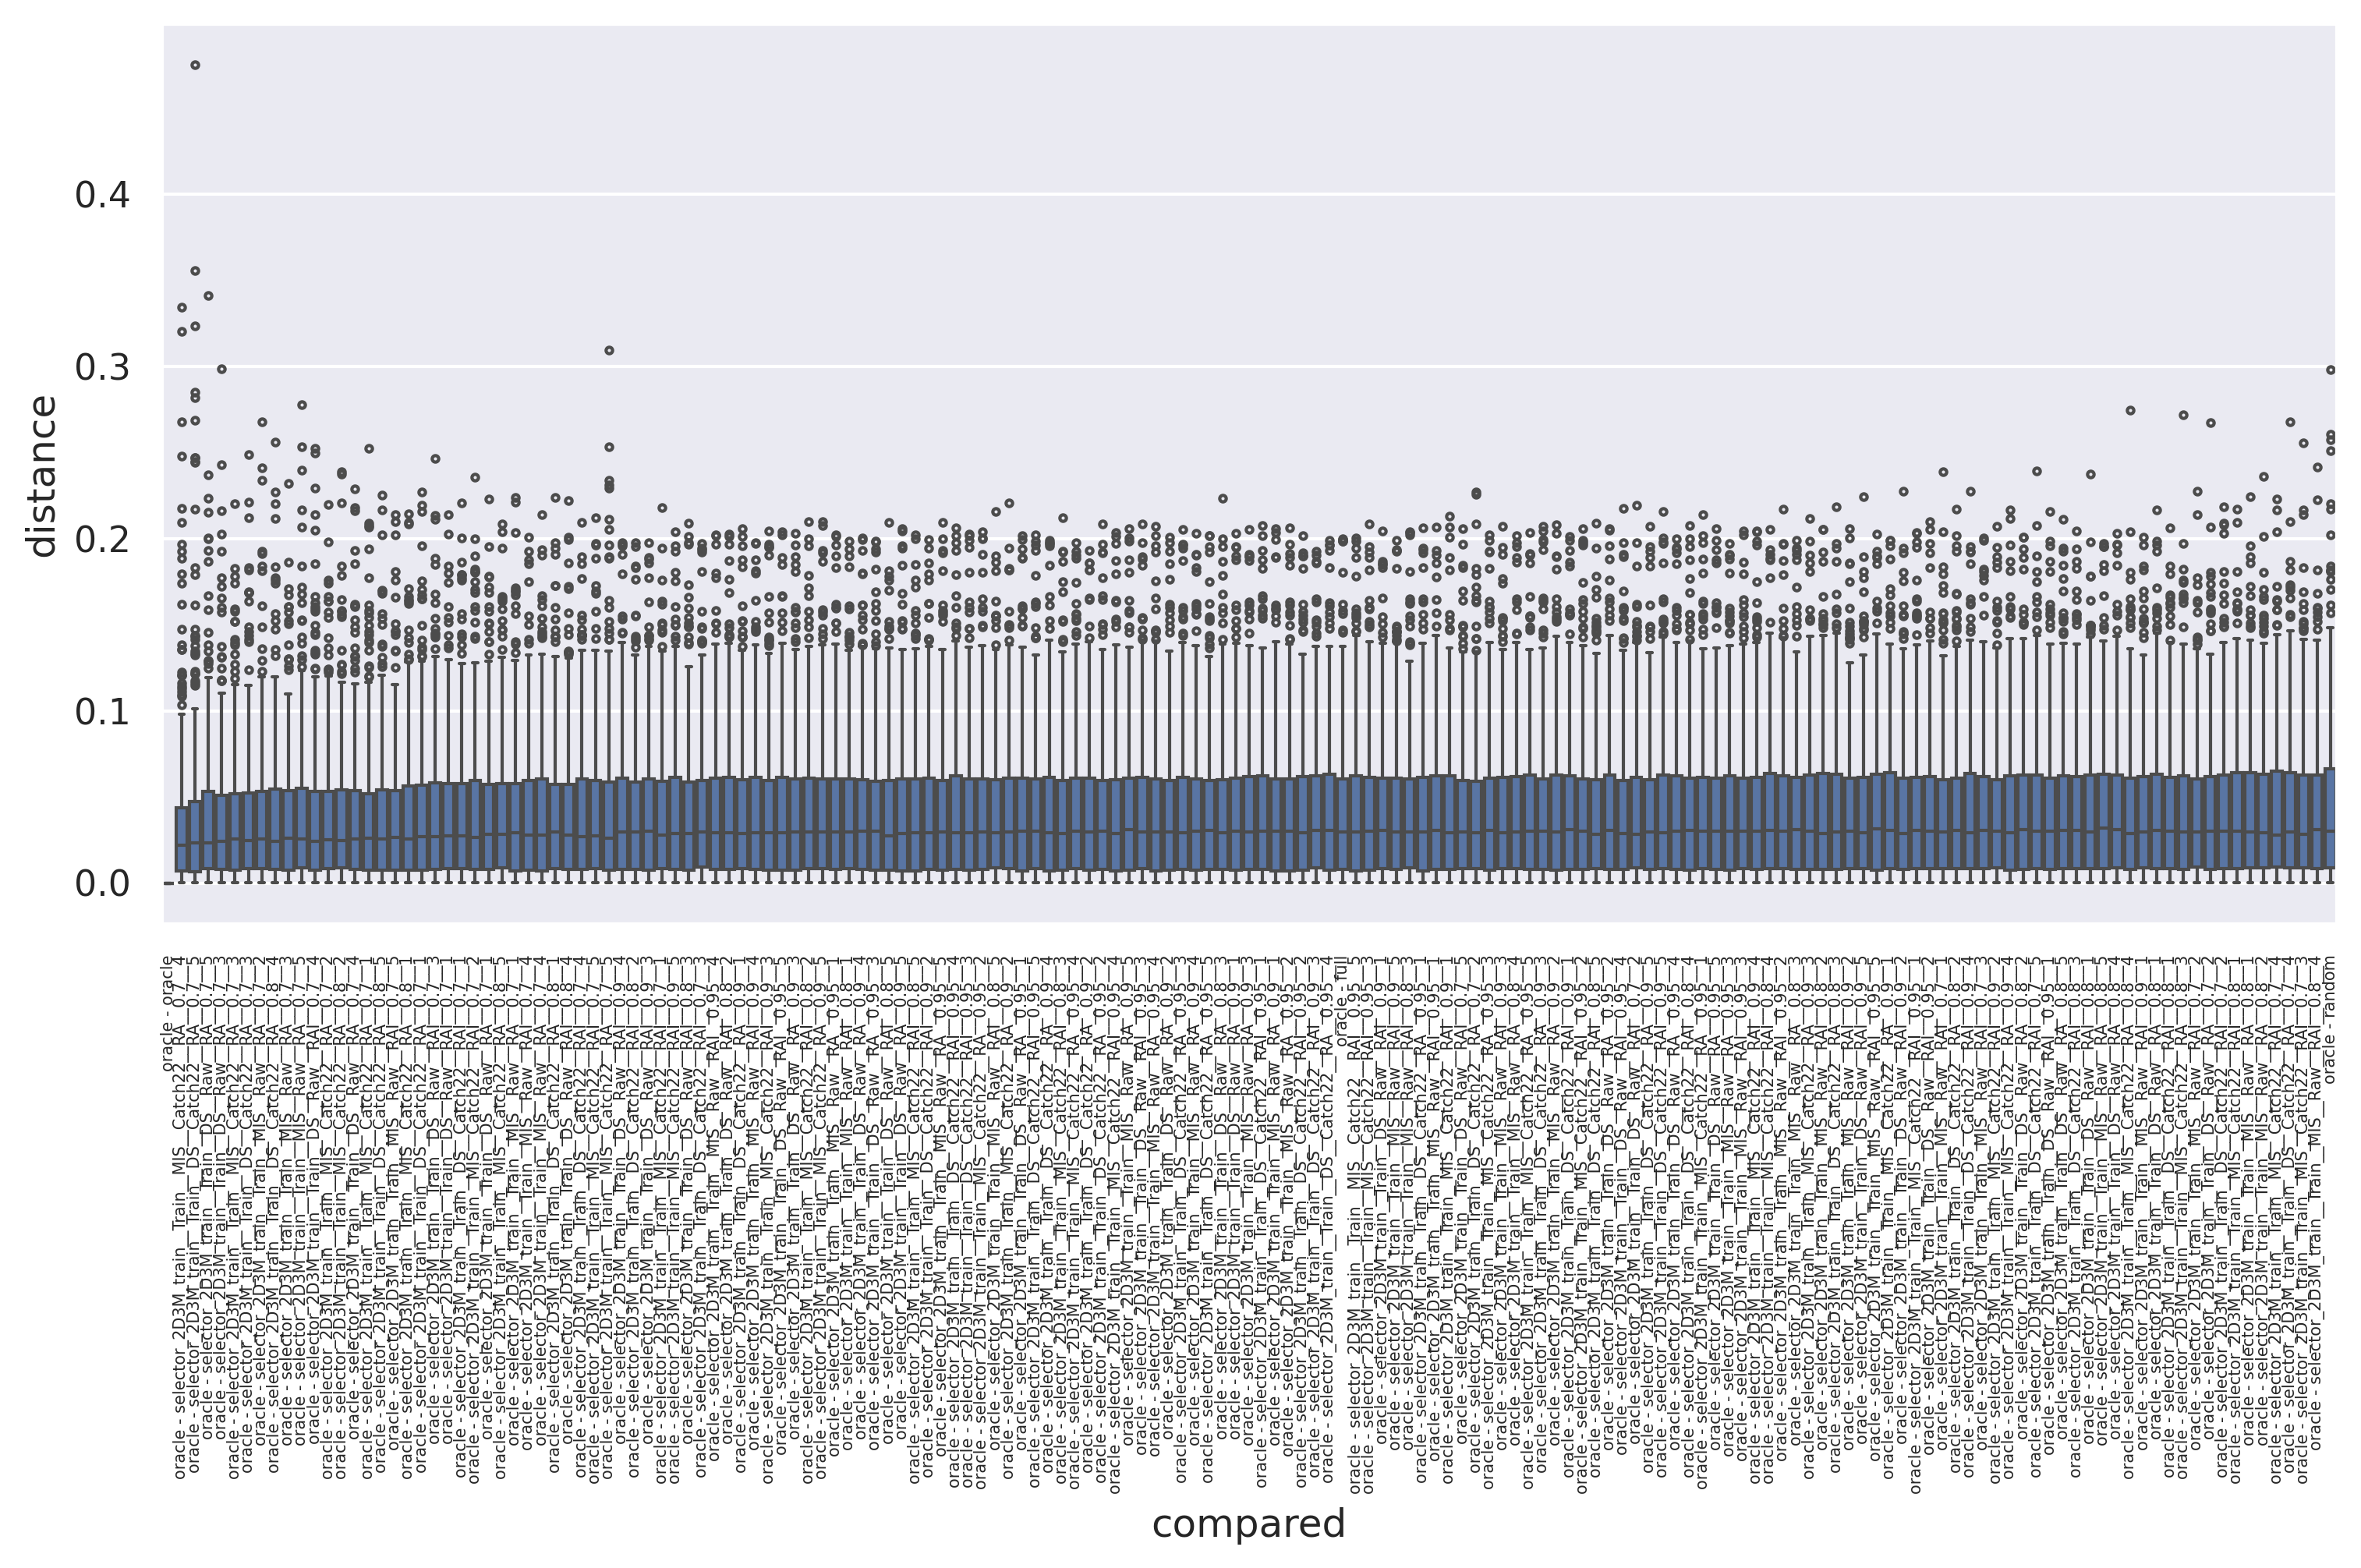

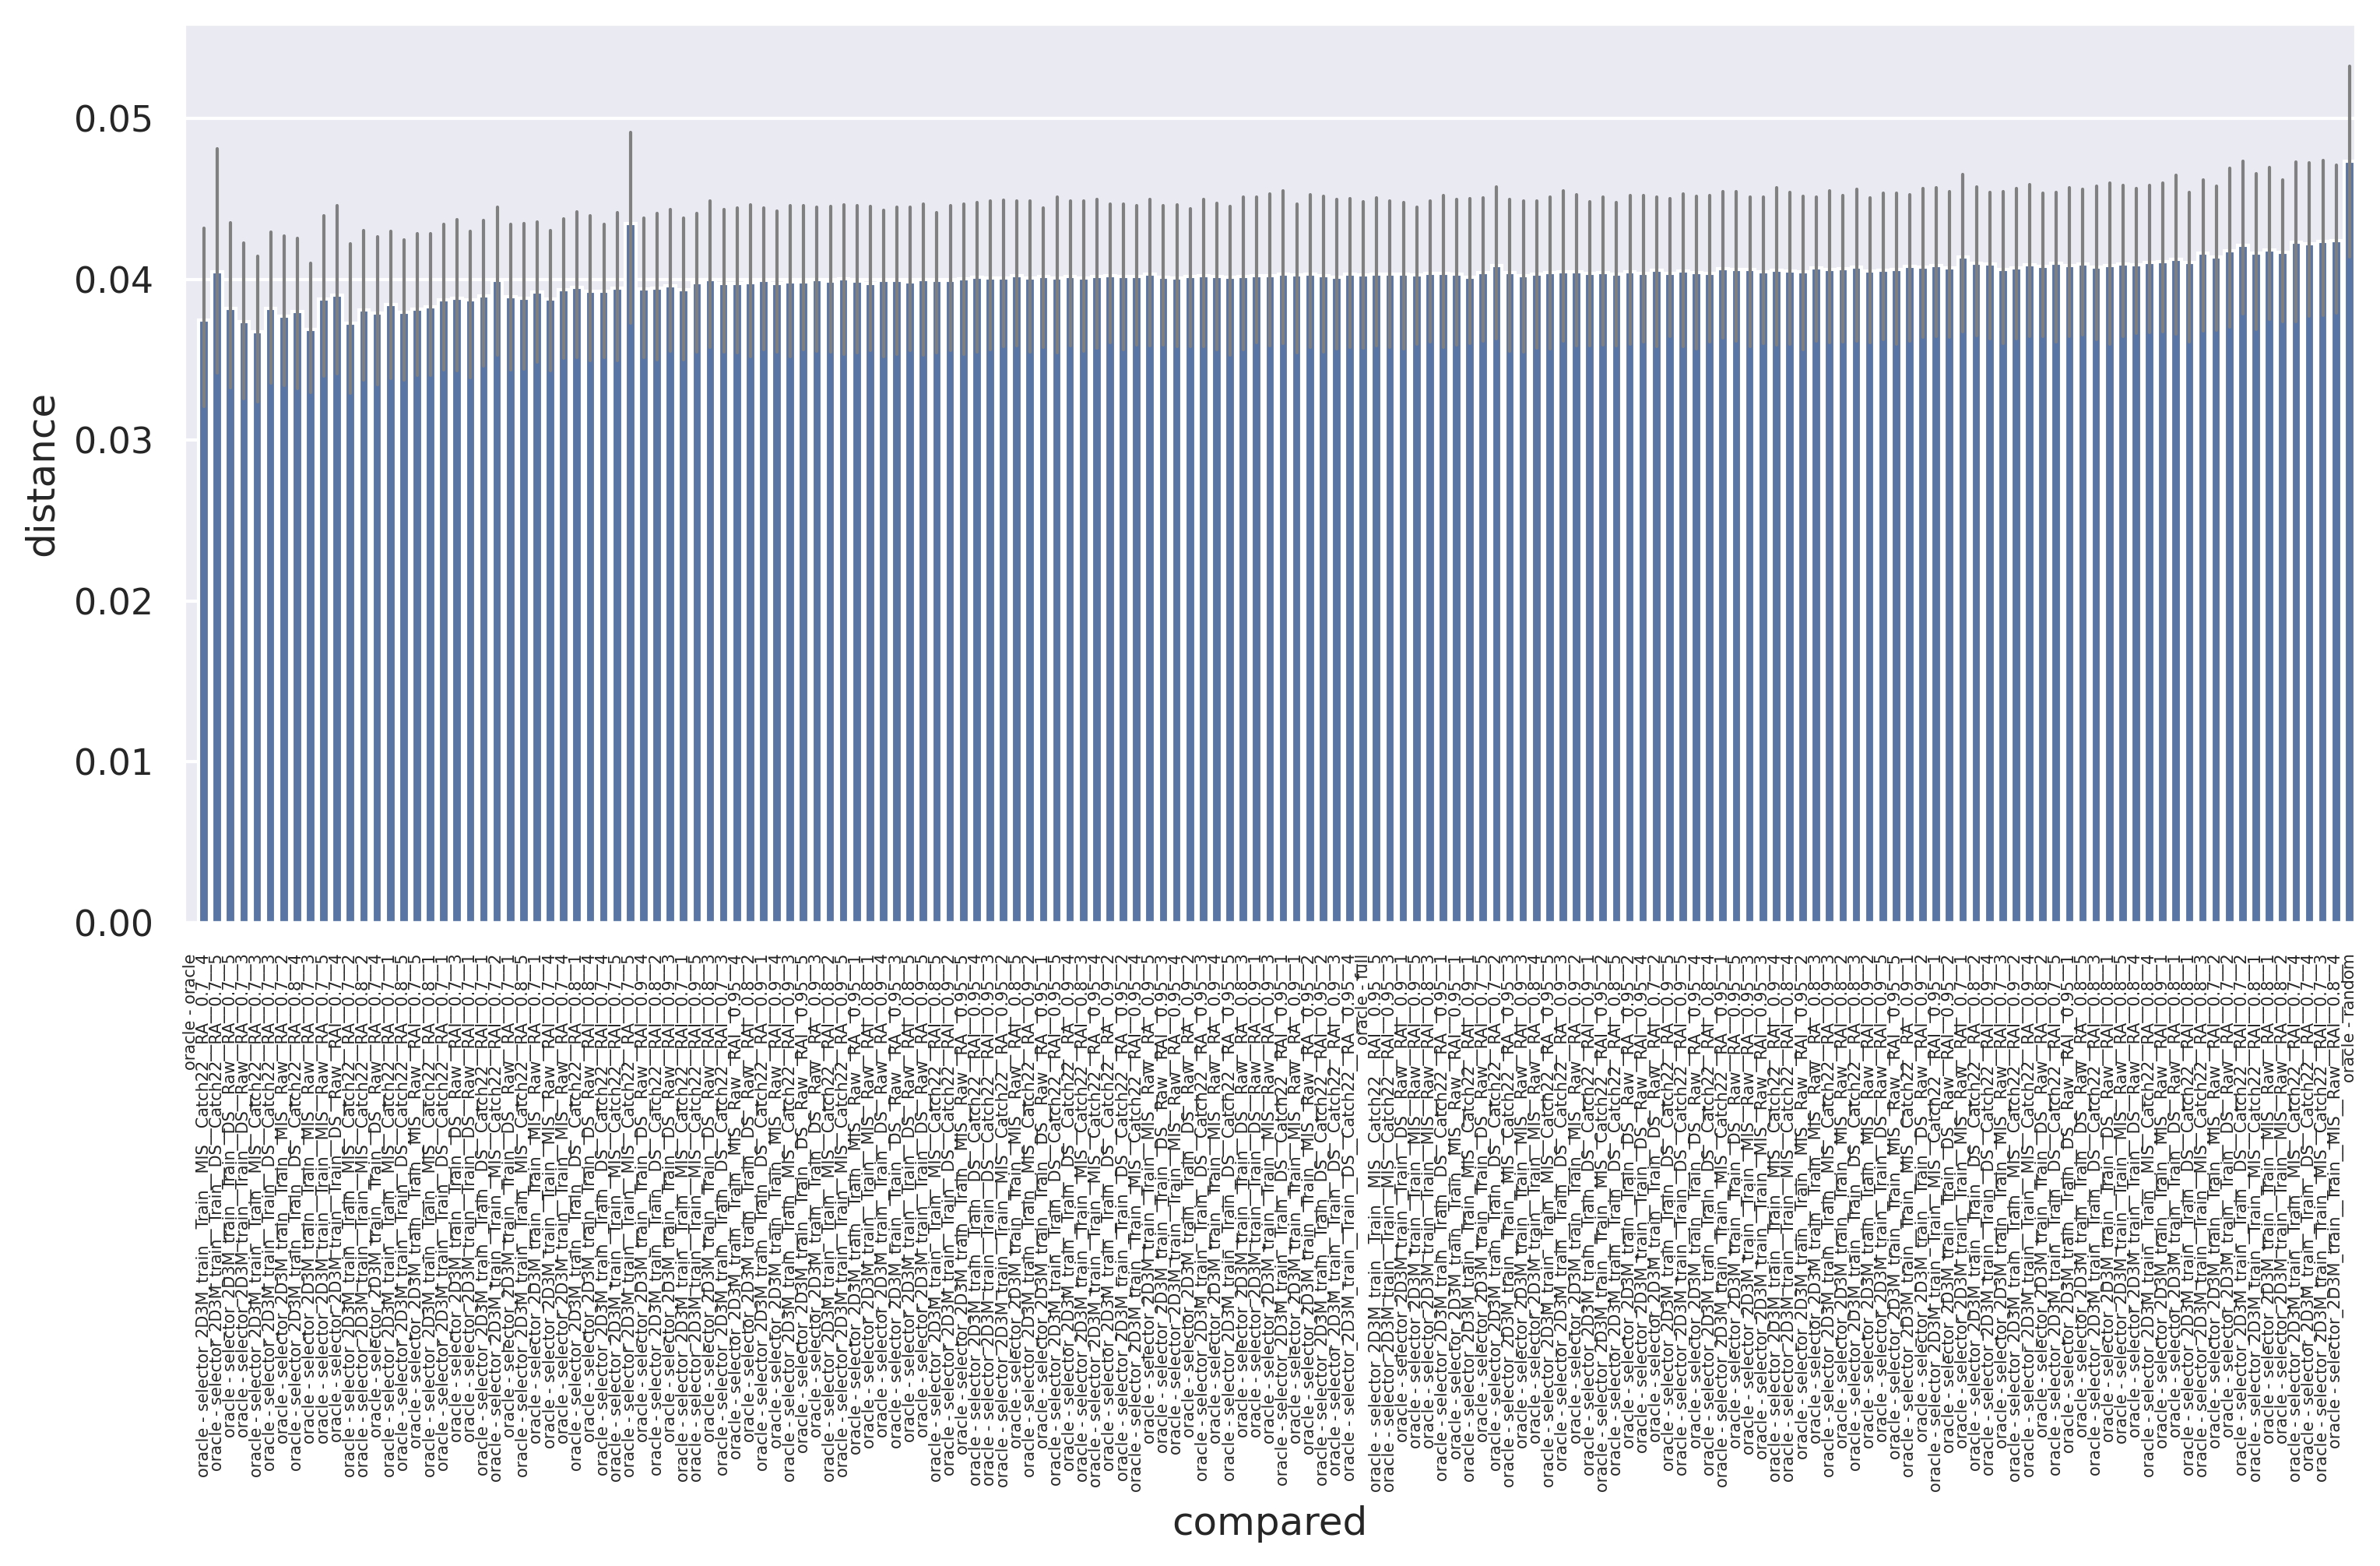

In [8]:
# Sort df by agg_fun
agg_fun = np.mean

sorted_series = diffs_per_instance.groupby(["compared"]).apply(lambda x: agg_fun(x["distance"])).sort_values()
sorter = list(sorted_series.index)

df = diffs_per_instance.sort_values(by="compared", key=lambda column: column.map(lambda e: sorter.index(e)))
df = df[df["distance_name"] == "l2_dist"]

fig = plt.figure(figsize=(12,5), dpi=300)
ax = fig.add_subplot(111)
ax = sns.boxplot(data=df, x="compared", y="distance", ax=ax, fliersize=2)
ax.tick_params(axis='x', labelrotation=90, labelsize=5)
# ax.set_ylim(0, ax.get_ylim()[1])
plt.show()

fig = plt.figure(figsize=(12,5), dpi=300)
ax = fig.add_subplot(111)
ax = sns.barplot(data=df, x="compared", y="distance", ax=ax, err_kws={"color": ".5", "linewidth": 1},)
ax.tick_params(axis='x', labelrotation=90, labelsize=5)
# ax.set_ylim(0, ax.get_ylim()[1])
plt.show()


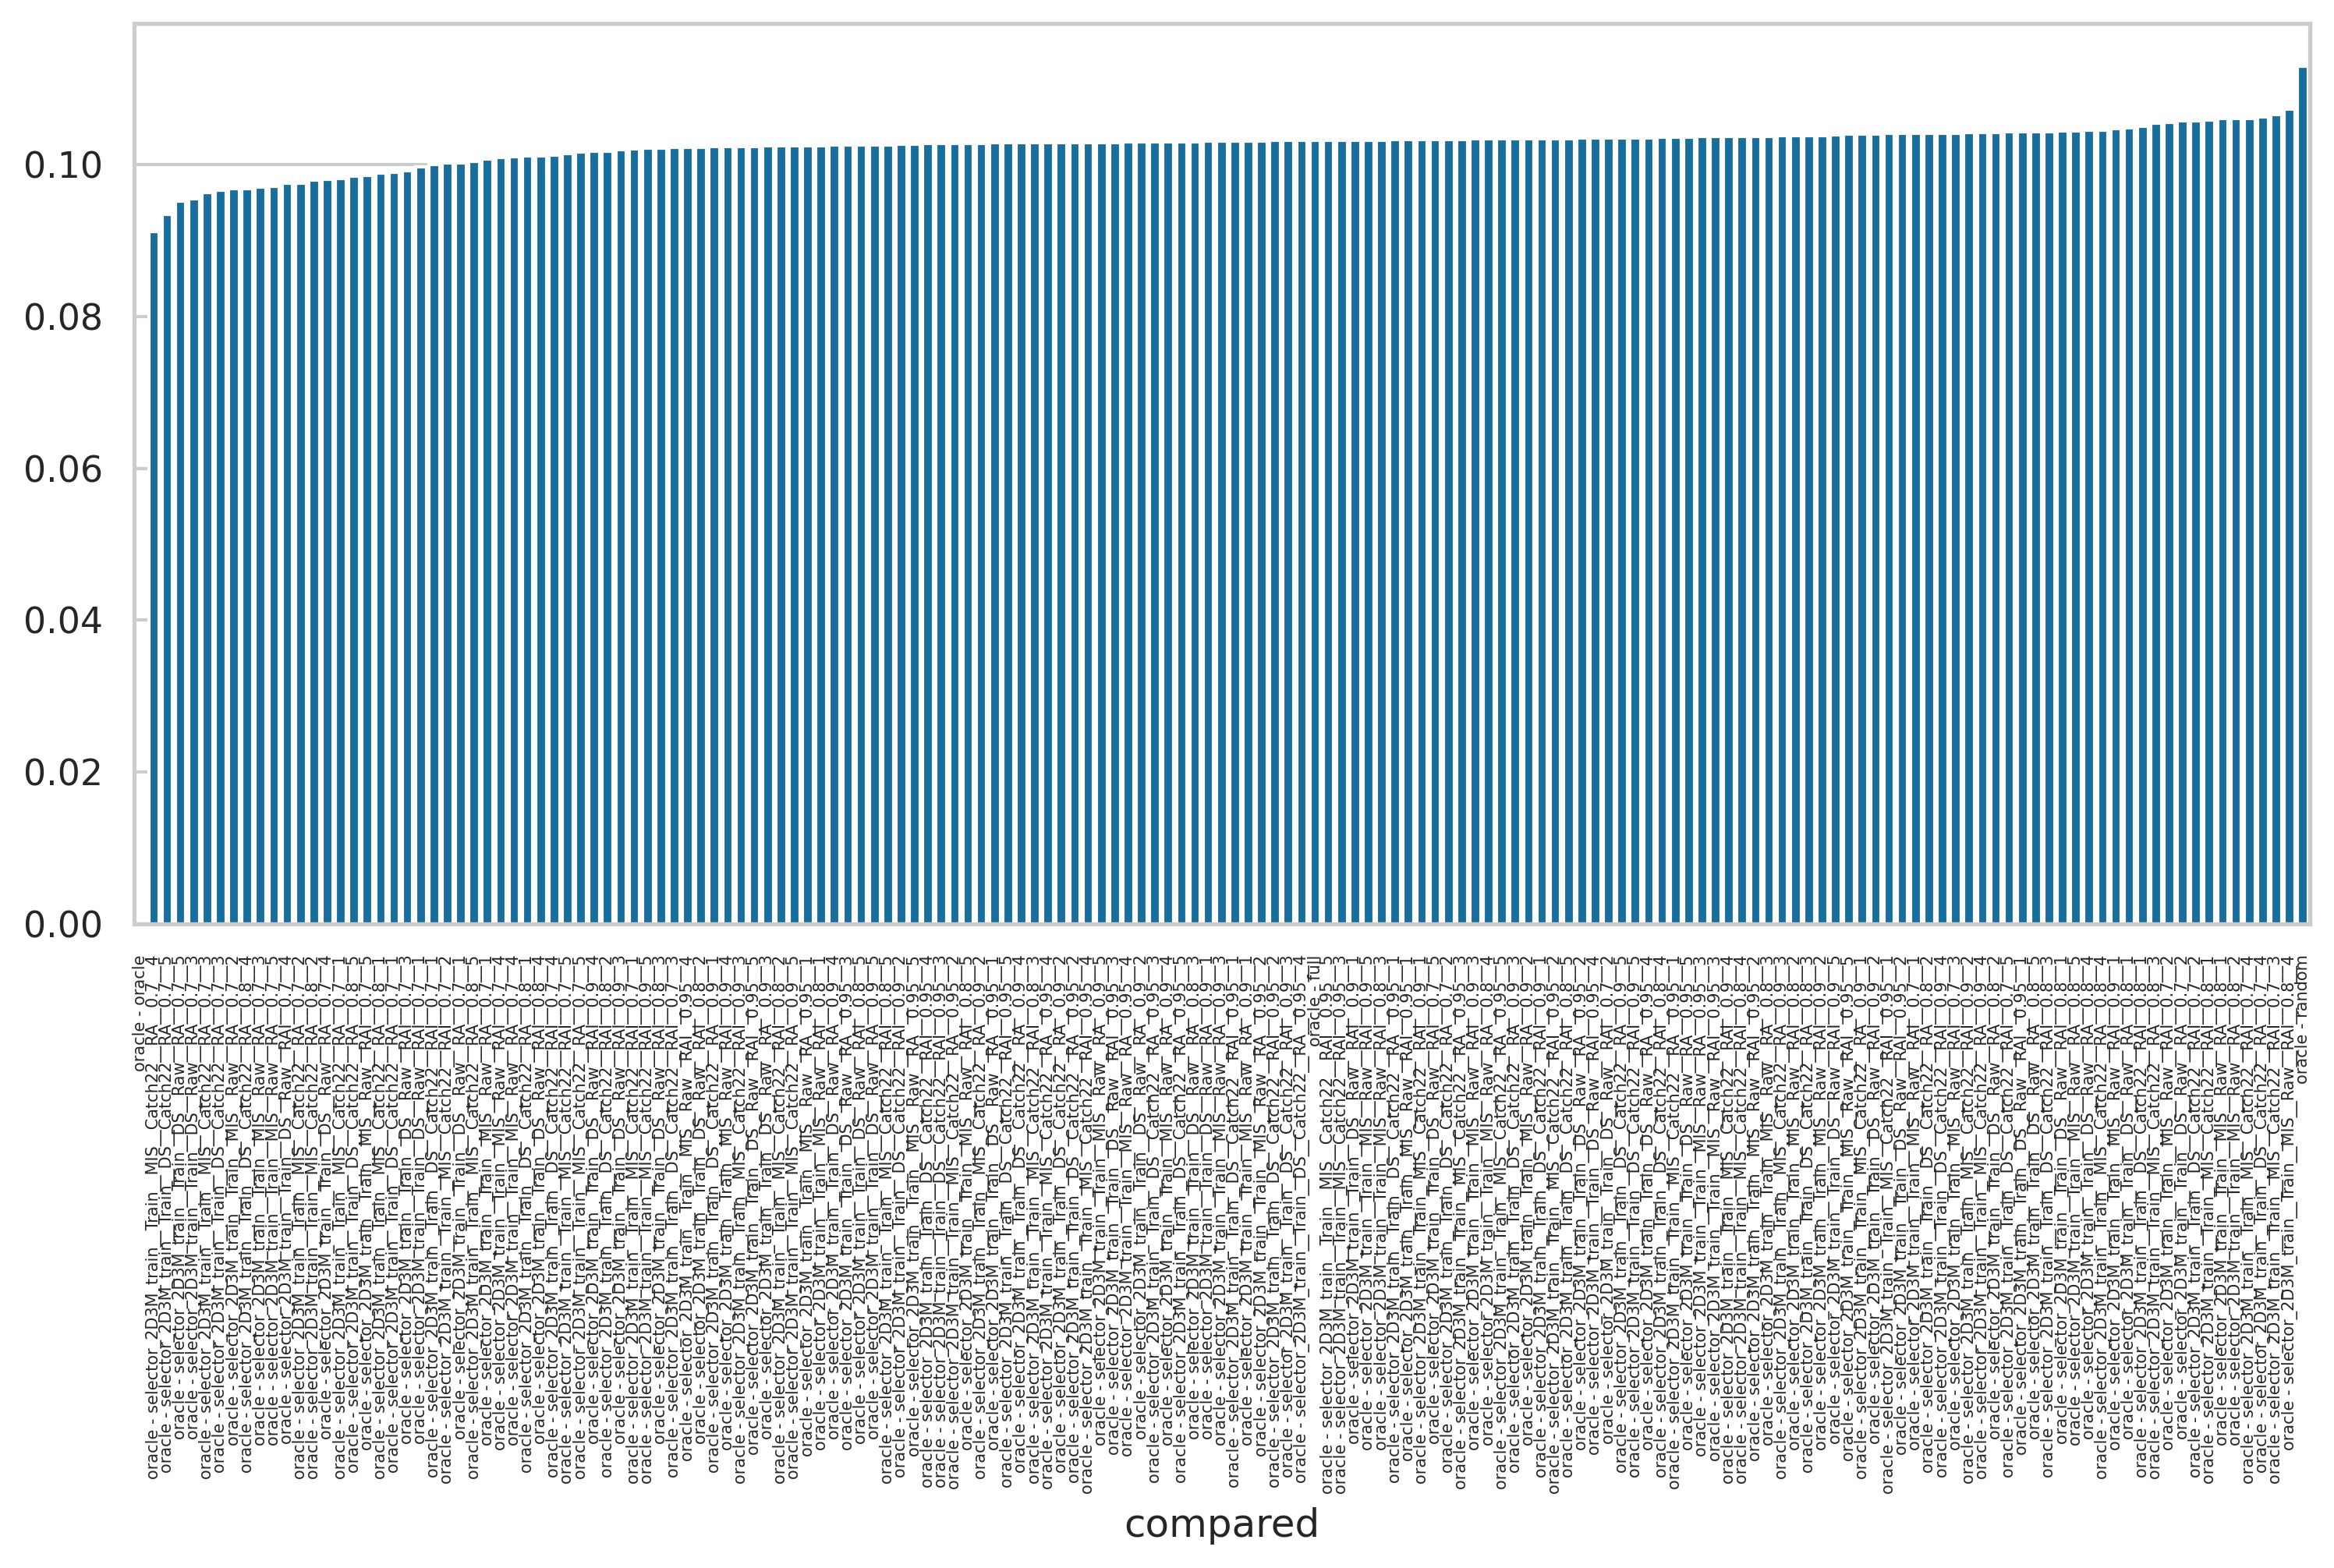

In [9]:
agg_fun = np.mean
diffs = diffs_per_instance.groupby(["compared"]).apply(lambda x: agg_fun(x["distance"]))
diffs = diffs.sort_values()
sns.set_style("whitegrid")
sns.set_palette("colorblind")
fig = plt.figure(figsize=(12,5), dpi=300)
ax = fig.add_subplot(111)
ax = sns.barplot(x=diffs.index, y=diffs.values, ax=ax)
ax.tick_params(axis='x', labelrotation=90, labelsize=5)
plt.show()
